In [1]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/ml-wakacyjne-wyzwanie-2025/data') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

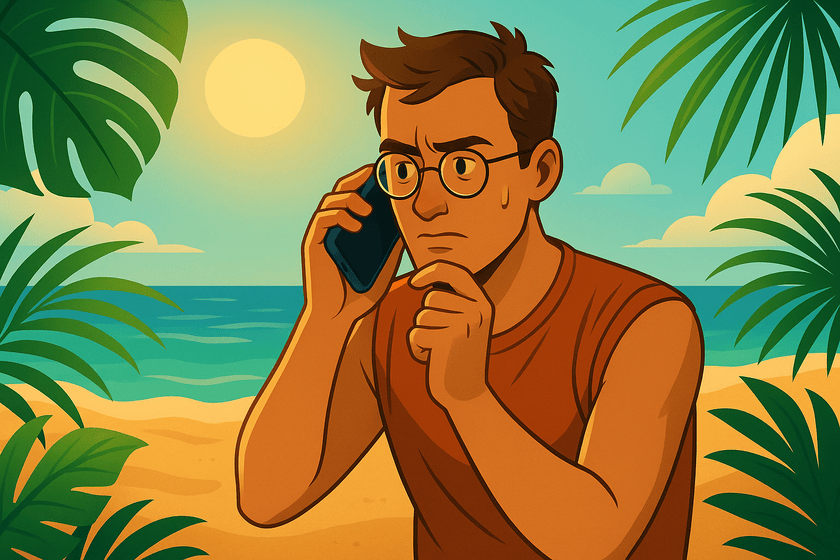

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [4]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [5]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

# Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne

Piersze zadanie uświadomiło mnie na ile tak właściwie sposobów można rozwiązać zadanie, tak naprawdę ile osóļ tyle podejść. Natomiast nie wszystkie decyzje apropo przygotowania danych w późniejszym czasie przy tworzeniu modelu będą właściwe.

### Z plusów które zrobiłem:
- właściwe uzupełniłem niewiadome Age stowując dobór losowy z prawdopodobieństwem zależnym od posiadanych danych
- niewiadome Fare uzupełniłem danymi z losowego próbkowania, z rozkładu prawdopodobieństwa opartego na istniejących danych o cenach biletów
- czytelnie przedstawiłem rozkład 
- wykresy były czytelne 
- w miare użyłem komentarze mimio późnej pory robienia zadania 
- zawarłem heatmape 


### Z minusów:
- usunąłem kolumne Cabin, ze względu na durze braki natomiast może ona mieć wpływ niejaki na uczenie modelu 
- do niewiadomuch Embarked stowrzyłem Unknown mimo tego ze byly tylko 2 braki zamiast uzupenłnić je najczęściej wstępownymi
- nie pomyślałem o zależności pomiędzy tym że wiek jest podany a przeżywalnością 
- brak wykresów dla wszystkich zmiennych 
- nie zauważyłem zależności pomiędzy Age a przeżywalnością z uwagi na to że wyszła bardzo mała korelacja na heatmapie co mnie zmyliło
a płeć wstawiałem na zasadzie boolen 
- nie wyświetliłem wykresów przed podstawieniem danych 
- wprowadzenie FamilySize jakoś przyszło mi to na myśl że osoby z dużą rodziną mają tendencje do poświęceń ale tak w symie jest to bez sensu bo zarówno synowi jak i ojcu na przykład przypisze ten sam FamilySize

# Dodaje 2 kolumny i usuwam Name i Ticket
- czy miał rodzinę binarną 0 - nie 1 - tak 
- czy była znana zmienna Cabin 

In [6]:
titanic_df["IsAlone"] = ((titanic_df["SibSp"] == 0) & (titanic_df["Parch"] == 0)).astype(int)

titanic_df = titanic_df.drop(columns=['Name', 'Ticket'])


# Podział bazy danych

<font color='red'>Co ważne według mnie podzielę baze danych na zbiór testowy treningowy i validacyjny przed uzupełnienim ich aby nie doszło do Data Leakage</font>

In [7]:
titanic_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare         98
Cabin       687
Embarked      2
IsAlone       0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, shuffle=True
)

Podział zbioru na: 
- treninogowy 60%
- testowy 20%
- walidacyjny 20%
<br>
<br>
Trochę słabo to było w notatkach wytłumaczone 

- gdzie X-to dane 
- Y to etykieta (Odpowiedz czy przeżył)

# Uzupełnienie niewaiadomych na podstawie zbioru treningowego

<font color='red'>Uzupełniam teraz braki ale tylko na podstawie zbioru treningowego, dlatego aby model testowy nie mógł zaglądać jakby w to. I mean aby nie było DataLeakage</font>

In [9]:
X_train.isna().sum(), X_val.isna().sum(), X_test.isna().sum()

(Pclass        0
 Sex           0
 Age         102
 SibSp         0
 Parch         0
 Fare         55
 Cabin       411
 Embarked      2
 IsAlone       0
 dtype: int64,
 Pclass        0
 Sex           0
 Age          38
 SibSp         0
 Parch         0
 Fare         27
 Cabin       142
 Embarked      0
 IsAlone       0
 dtype: int64,
 Pclass        0
 Sex           0
 Age          37
 SibSp         0
 Parch         0
 Fare         16
 Cabin       134
 Embarked      0
 IsAlone       0
 dtype: int64)

In [10]:
age_dist = X_train['Age'].value_counts(normalize=True)

def fill_age(df):
    mask = df['Age'].isna()
    df.loc[mask, 'Age'] = np.random.choice(
        age_dist.index,
        size=mask.sum(),
        p=age_dist.values
    )
    return df

X_train = fill_age(X_train)
X_val = fill_age(X_val)
X_test = fill_age(X_test)

Uzupełnienie braków w Age ale tylko na podstawie rozkładu z zbioru treningowego

In [11]:
fare_dist = X_train['Fare'].value_counts(normalize=True)

def fill_fare(df):
    mask = df['Fare'].isna()
    df.loc[mask, 'Fare'] = np.random.choice(
        fare_dist.index,
        size=mask.sum(),
        p=fare_dist.values
    )
    return df

X_train = fill_fare(X_train)
X_val = fill_fare(X_val)
X_test = fill_fare(X_test)

Uzupełnienie braków w Fare na tej samej zasadzie 

I tak wiem mogę zrobić 1 funkcję do tego 

I teraz mimmo to że widzę że te 2 braki apropo Embraked trafiły do zbioru treningowego to i tak stworzę fragemnt kodu uzupełniający do wszystkich ponieważ przy ponownym losowym podziale braki mogą trafić do innych zbiorów

In [12]:
embarked_sr = X_train['Embarked'].mode()[0]

def embarked_mode(df):
    mask = df['Embarked'].isna()
    df.loc[mask, 'Embarked'] = embarked_sr
    return df

X_train = embarked_mode(X_train)
X_val = embarked_mode(X_val)
X_test = embarked_mode(X_test)

Uzupełnienei Embarked modalną

Teraz uzupełnię brakujące wartości Cabin jako U-unknown w zbiorach

In [13]:
def cabin_unknow(df):
    df['Cabin'] = df['Cabin'].fillna('U')
    return df

X_train = cabin_unknow(X_train)
X_val = cabin_unknow(X_val)
X_test = cabin_unknow(X_test)

In [14]:
X_train.isna().sum(), X_val.isna().sum(), X_test.isna().sum()

(Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Fare        0
 Cabin       0
 Embarked    0
 IsAlone     0
 dtype: int64,
 Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Fare        0
 Cabin       0
 Embarked    0
 IsAlone     0
 dtype: int64,
 Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Fare        0
 Cabin       0
 Embarked    0
 IsAlone     0
 dtype: int64)

Brak braków w zbiorach

# Sprawdzenie porpawności typów dnaych

In [15]:
X_train.dtypes, X_val.dtypes, X_test.dtypes

(Pclass        int64
 Sex          object
 Age         float64
 SibSp         int64
 Parch         int64
 Fare        float64
 Cabin        object
 Embarked     object
 IsAlone       int64
 dtype: object,
 Pclass        int64
 Sex          object
 Age         float64
 SibSp         int64
 Parch         int64
 Fare        float64
 Cabin        object
 Embarked     object
 IsAlone       int64
 dtype: object,
 Pclass        int64
 Sex          object
 Age         float64
 SibSp         int64
 Parch         int64
 Fare        float64
 Cabin        object
 Embarked     object
 IsAlone       int64
 dtype: object)

Tutaj widzimy że trzeba przerobić Sex Embarked i Cabin i w sumie nie potrzebnie dodałem czy kolumnę czy znana jest kabina więc ją usunę

### Sex

In [16]:
sex = {"male": 0, "female": 1}
# heh segz plz kill me 
X_train["Sex"] = X_train["Sex"].map(sex)
X_val["Sex"]   = X_val["Sex"].map(sex)
X_test["Sex"]  = X_test["Sex"].map(sex)

### Embarked

In [17]:
embarked_mapping = {val: idx for idx, val in enumerate(X_train["Embarked"].dropna().unique())}

X_train["Embarked"] = X_train["Embarked"].map(embarked_mapping)
X_val["Embarked"]   = X_val["Embarked"].map(embarked_mapping)
X_test["Embarked"]  = X_test["Embarked"].map(embarked_mapping)

#nowe dostaną -1 
X_train["Embarked"] = X_train["Embarked"].fillna(-1)
X_val["Embarked"]   = X_val["Embarked"].fillna(-1)
X_test["Embarked"]  = X_test["Embarked"].fillna(-1)

### Cabin

In [19]:
#Wyciągniecie litery 
X_train["Cabin_letter"] = X_train["Cabin"].str[0]
X_val["Cabin_letter"]   = X_val["Cabin"].str[0]
X_test["Cabin_letter"]  = X_test["Cabin"].str[0]

cabin_mapping = {val: idx for idx, val in enumerate(X_train["Cabin_letter"].dropna().unique())}

X_train["Cabin_letter"] = X_train["Cabin_letter"].map(cabin_mapping)
X_val["Cabin_letter"]   = X_val["Cabin_letter"].map(cabin_mapping)
X_test["Cabin_letter"]  = X_test["Cabin_letter"].map(cabin_mapping)

#nowe dostaną -1 
X_train["Cabin_letter"] = X_train["Cabin_letter"].fillna(-1)
X_val["Cabin_letter"]   = X_val["Cabin_letter"].fillna(-1)
X_test["Cabin_letter"]  = X_test["Cabin_letter"].fillna(-1)

Zarówno dla Embarked jak i Cabin zmapowaliśmy dane na podstawie zbioru treningowego dlatego, aby nowe dane które mogłby wystąpić w zbiorze walidacyjnym i testowym odpowiednio przypisać, aby nie doszło do data leakage w procesie treningowym 

### Pozbycie się Cabin bo mamy Cabin_letter

In [21]:
X_train = X_train.drop(columns=["Cabin"])
X_val   = X_val.drop(columns=["Cabin"])
X_test  = X_test.drop(columns=["Cabin"])

# Dummy Classifier

Tworzymy Dummy classifier aby mieć punkt odniesienia i aby odkryć baseline, czyli próg wejścia 
<br>
Wybieramy za strategy most_frequent ponieważ mniej osób przeżyło i pechowe założenie że każdy zginął jest w tym przypadku naszym baselinerem

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

baseline = DummyClassifier(strategy='most_frequent', random_state=1)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       105
           1       0.00      0.00      0.00        74

    accuracy                           0.59       179
   macro avg       0.29      0.50      0.37       179
weighted avg       0.34      0.59      0.43       179



/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

array([[105,   0],
       [ 74,   0]])

Jako że użyłem most_frequent 59% przypadków przewidział dobrze 

Tutaj jescze dla porównania wywołamy DummyClassifier dla stratified przewiduje losowo, ale zachowując proporcje klas w zbiorze treningowym

In [32]:
baseline = DummyClassifier(strategy='stratified', random_state=1)
baseline.fit(X_train, y_train)
y_pred_stratified = baseline.predict(X_test)

print(classification_report(y_test, y_pred_stratified))
confusion_matrix(y_test, y_pred_stratified)

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       105
           1       0.40      0.35      0.37        74

    accuracy                           0.51       179
   macro avg       0.49      0.49      0.49       179
weighted avg       0.50      0.51      0.51       179



array([[66, 39],
       [48, 26]])

Tu mamy accuracy 51% czyli spadło 
- macro avg 0.49 → to średnia po klasach
- weighted avg 0.51 → trochę faworyzuje klasę 0, bo jest liczniejsza


# Zaczynamy tworzyć nasze chocki klocki czyli wybieramy model 

Ej cosiek

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


Wybieramy:
- Drzewo decyzyjne
- KNN
- SVM

## Drzewo decyzyjne

In [71]:
drewno = DecisionTreeClassifier(random_state=1, max_depth=5)
drewno.fit(X_train, y_train)
y_pred_drewno = drewno.predict(X_test)

print(classification_report(y_test, y_pred_drewno))
confusion_matrix(y_test, y_pred_drewno)

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       105
           1       0.80      0.66      0.73        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



array([[93, 12],
       [25, 49]])

Widzimy tutaj że jest średnio accuracy 79%, gorzej radzi sobie z przypisywaniem 1 czyli tego że osoba przeżyła trzeba będzie dobrać odpowiedni max_depth i min_samples_split

Trzeba dobrać odpowiedni max_depth

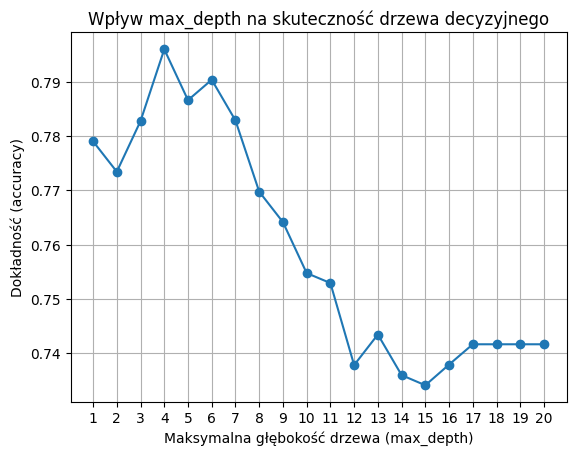

In [72]:

depths = range(1, 21)
scores = []

for d in depths:
    clf = DecisionTreeClassifier(random_state=1, max_depth=d)
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores.append(score)

plt.plot(depths, scores, marker='o')
plt.xlabel('Maksymalna głębokość drzewa (max_depth)')
plt.ylabel('Dokładność (accuracy)')
plt.title('Wpływ max_depth na skuteczność drzewa decyzyjnego')
plt.xticks(depths)
plt.grid(True)
plt.show()

Widzimy że najlepsze wyniki osiągamy dla głębkości 4

<font color='red'>Czemu tu spada na 5 i odbija na 6</font>

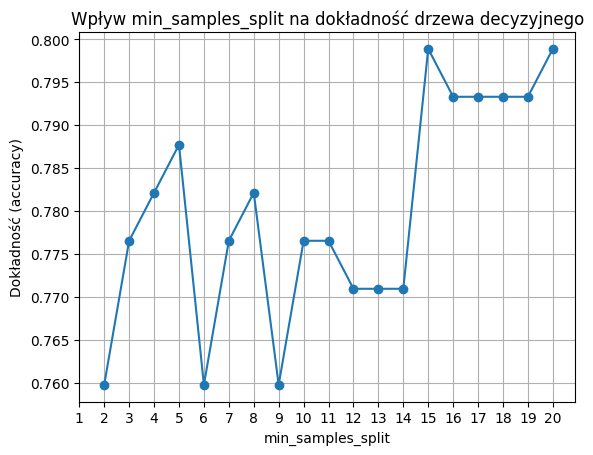

In [76]:
min_samples_splits = range(2, 21)  # Zakres od 2 do 20
accuracies = []

for mss in min_samples_splits:
    clf = DecisionTreeClassifier(min_samples_split=mss, random_state=1)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    accuracies.append(acc)

plt.plot(min_samples_splits, accuracies, marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Dokładność (accuracy)')
plt.title('Wpływ min_samples_split na dokładność drzewa decyzyjnego')
plt.xticks(depths)
plt.grid(True)
plt.show()

Tu widzimy że min_sample_split accuracy wychodzi najlepiej dla 15 i 20 

Teraz sprawdzmy accuracy od 2 parametrów jednocześnie tak aby nie okazało się że dobierzemy z 2 wykresów osobno i nie będzie to najdokładniejszy model

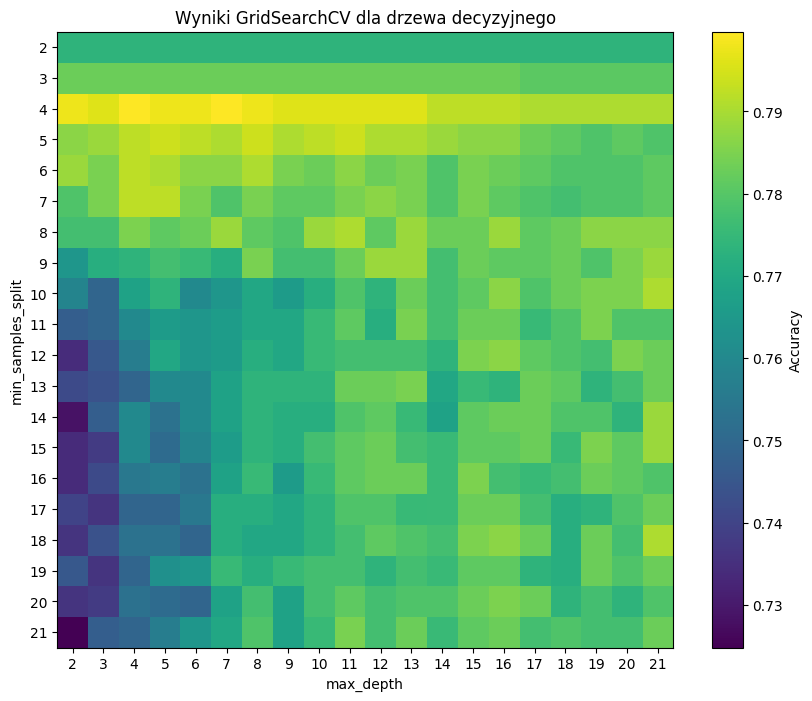

In [87]:
param_grid = {
    'min_samples_split': list(range(2, 22)),
    'max_depth': list(range(2, 22))
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']
scores_matrix = np.array(scores).reshape(len(param_grid['min_samples_split']), len(param_grid['max_depth']))

plt.figure(figsize=(10, 8))
im = plt.imshow(scores_matrix, interpolation='nearest', cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.colorbar(im, label='Accuracy')
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.yticks(np.arange(len(param_grid['min_samples_split'])), param_grid['min_samples_split'])
plt.title('Wyniki GridSearchCV dla drzewa decyzyjnego')
plt.show()

Widzimy tu na wykresie najbardziej optymalne parametry dla naszego modelu

I tak wiem że jest za duże jak na nasze dane 

In [89]:
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']

drewno_best = DecisionTreeClassifier(min_samples_split=best_split, max_depth=best_depth, random_state=1)
drewno_best.fit(X_train, y_train)

y_pred_best = drewno_best.predict(X_test)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179

[[95 10]
 [26 48]]


Czy jest dobrze ? 
<br>
No tak średnio bym powiedział, no tak średnio
<br>
Accuracy 80% przypadków przewidział dobrze
<br>
Ale nadal mamy niedobrze w klasyfikacji recall przeżywalności

Co teraz robić - zabawa wagami klas 

In [90]:
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']

drewno_best = DecisionTreeClassifier(class_weight="balanced"
,criterion="entropy",min_samples_split=best_split, max_depth=best_depth, random_state=1)
drewno_best.fit(X_train, y_train)

y_pred_best = drewno_best.predict(X_test)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

[[89 16]
 [19 55]]


No już coraz bliżej mamy nadal 80% accuracy ale podyżyszliśmy recall w przeżywalności 

<font color='red'>Update po 1.5 h bawienia się thresholdem już lepeij na tym modelu się chyba nie da </font>
<br>
<a href="https://open.spotify.com/track/3pZ2zNxkjvQ9GCRnfkBL1o?si=ca21e65a23cb456c">ballada o jamniku</href>

Porównanie zwykłego modelu bez hiperparametrów do tego z hiperparamtrami 

## KNN

In [96]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
confusion_matrix(y_test, y_pred_knn)

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       105
           1       0.61      0.47      0.53        74

    accuracy                           0.66       179
   macro avg       0.65      0.63      0.63       179
weighted avg       0.65      0.66      0.65       179



array([[83, 22],
       [39, 35]])

Mamy bardzo słabe accuracy 66% oraz fatalny recall dla 1 

I tu pojawia się pytanie ile sąsiadów brać pod uwagę w uczeniu modelu aby to wydedukować trzeba walnąć walidację krzyżową 

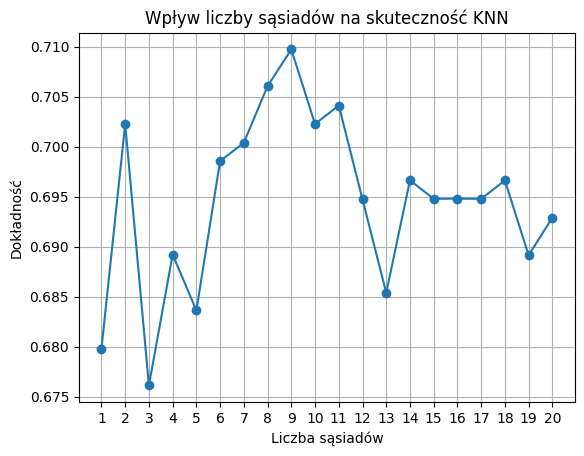

In [98]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = range(1, 21)
scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5).mean()
    scores.append(score)

plt.plot(neighbors, scores, marker='o')
plt.xlabel('Liczba sąsiadów')
plt.ylabel('Dokładność')
plt.title('Wpływ liczby sąsiadów na skuteczność KNN')
plt.xticks(neighbors)
plt.grid(True)
plt.show()

I tak patrząc na ten wykres widzisz niby że dla głębokości 9 mamy najlepszą dokładność, i niby wszystko widać ale jak tak się zaczniesz zastanawiać dlaczego jest tak mała dokładaność dla 3 i czemu na 13 spada 

In [97]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
confusion_matrix(y_test, y_pred_knn)

              precision    recall  f1-score   support

           0       0.64      0.81      0.72       105
           1       0.57      0.36      0.45        74

    accuracy                           0.63       179
   macro avg       0.61      0.59      0.58       179
weighted avg       0.62      0.63      0.61       179



array([[85, 20],
       [47, 27]])

I się trochę wywalił na zbiorze testowym doszło do przeuczenia
<br>
Model nauczył się zbyt dobrze danych treningowych, ale nie generalizuje na nowe dane (overfitting)
<br>
No jest nie dobrze 

I osobiście uważam że ten typ uczenia maszynowego widać że źle współgra z naszymi danymi więc przejdę do następnego

## SVM

In [63]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=1)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.66      0.94      0.78       105
           1       0.79      0.31      0.45        74

    accuracy                           0.68       179
   macro avg       0.73      0.63      0.61       179
weighted avg       0.72      0.68      0.64       179

[[99  6]
 [51 23]]


A teraz dla przykładu zostawię model z początkowymi wartościami i będę go teraz dostrajał 

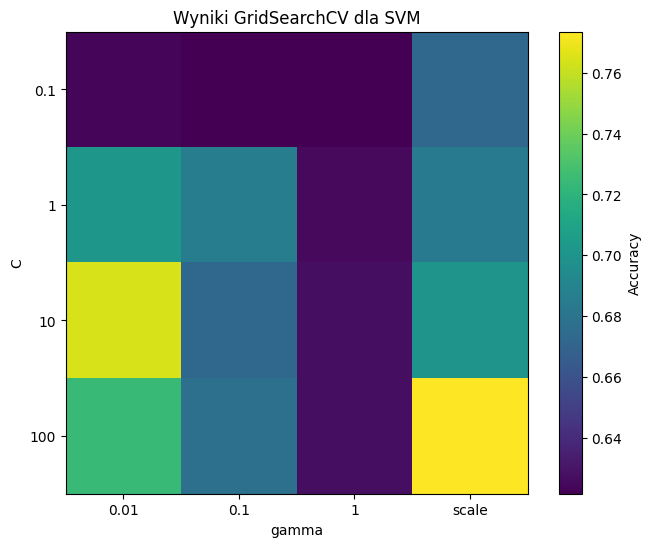

In [100]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale']
}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']
scores_matrix = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
im = plt.imshow(scores_matrix, interpolation='nearest', cmap='viridis')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(im, label='Accuracy')
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'])
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Wyniki GridSearchCV dla SVM')
plt.show()

Z wykresu widzimy że zbyt małe C powoduje niedouczenie modeul najlepsze osiąga on dla C = 10, natomiast najlepsza gamma występuje dla 'scale'

In [101]:
best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

svm_best = SVC(kernel='rbf', C=best_C, gamma=best_gamma, random_state=1)
svm_best.fit(X_train, y_train)

y_pred_best = svm_best.predict(X_test)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

[[88 17]
 [18 56]]


No i co accuracy 80 % ale nadal słabiej radzi sobie z przeżywalnością - 1 

# Wnioski

           Model  Accuracy  Precision    Recall  F1-score
0  Decision Tree  0.804469   0.803641  0.804469  0.803824
1            SVM  0.804469   0.804117  0.804469  0.804268


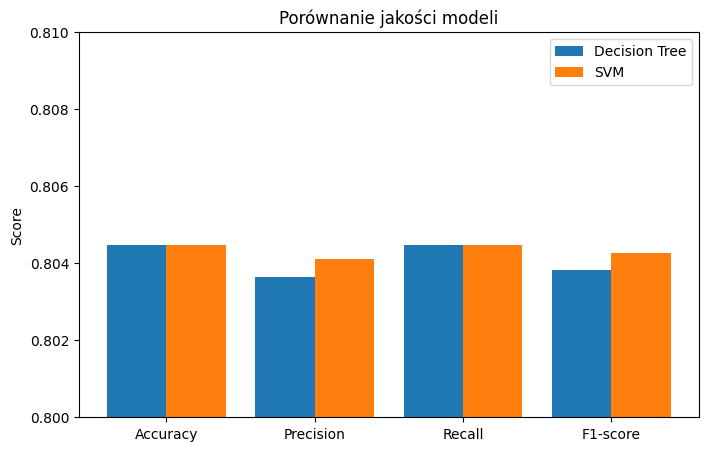

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drzewo
y_pred_tree = drewno_best.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
prec_tree = precision_score(y_test, y_pred_tree, average='weighted')
rec_tree = recall_score(y_test, y_pred_tree, average='weighted')
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')

# SVM
y_pred_svm = svm_best.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted')
rec_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

results = pd.DataFrame({
    "Model": ["Decision Tree", "SVM"],
    "Accuracy": [acc_tree, acc_svm],
    "Precision": [prec_tree, prec_svm],
    "Recall": [rec_tree, rec_svm],
    "F1-score": [f1_tree, f1_svm]
})
print(results)

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

x = range(len(metrics))
tree_scores = [acc_tree, prec_tree, rec_tree, f1_tree]
svm_scores = [acc_svm, prec_svm, rec_svm, f1_svm]

plt.figure(figsize=(8,5))
plt.bar([i-0.2 for i in x], tree_scores, width=0.4, label="Decision Tree")
plt.bar([i+0.2 for i in x], svm_scores, width=0.4, label="SVM")

plt.xticks(x, metrics)
plt.ylim(0.8,0.81)
plt.ylabel("Score")
plt.title("Porównanie jakości modeli")
plt.legend()
plt.show()

- Oba modele mają prawie identyczny accuracy
- SVM wypadan minimalnie lepiej od drzewa mimo włożonej większej pracy w nie 
- Model KNN wypadł dużo gorzej od innych nie pasuje do tego typu zadania 
- W porównaniu do baseline (59%) to poprawiliśmy wynik modelu
- Czy dało się lepiej? Można było użyć lepszego modelu typu Gradient Boosting albo dalej stroić hiperparametry
- Nie warto bawić się thresholedm w późnych godzinach 

<a href="https://open.spotify.com/track/0EUxk35x2a4KhZj9OE9uMC?si=c5b6a96f11374fb4">polecam słuchałem na loopie</href>